##Lab 2: KNN Classifier

In this lab, we will implement a K nearest neighbor classifier on CIFAR10 dataset. We will use cross validation to find the optimal K.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
%matplotlib inline

# helper functions for data loading
def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding='latin1')
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte


# Downloading the CIFAR-10 dataset

In [30]:
import urllib.request
import tarfile

url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
urllib.request.urlretrieve(url, "cifar-10-python.tar.gz")

tar = tarfile.open("cifar-10-python.tar.gz", "r:gz")
tar.extractall()
tar.close()

# Loading raw files and reading them as training and testing datasets

In [31]:
cifar10_dir = './cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Checking the size of the training and testing data
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


# Visualizing dataset samples

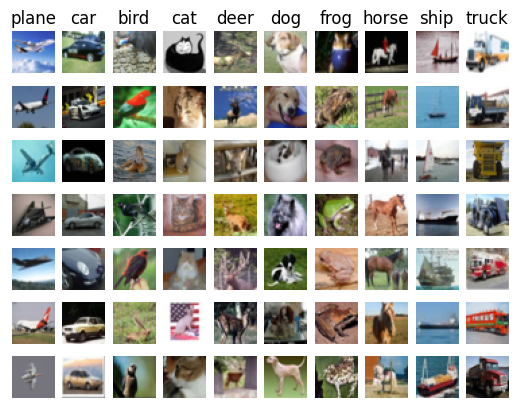

In [32]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# Data subsampling

In [33]:
# Memory error prevention by subsampling data

num_training = 10000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 1000
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [34]:
# reshaping data and placing into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)


(10000, 3072) (1000, 3072)


# Performing K-NN

In [35]:
class KNearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1, num_loops=0):
        dists = self.compute_distances(X)
        return self.predict_labels(dists, k=k)

    # complete the following function
    # so that it returns a distance matrix
    # (Euclidian distance between X and self.X_train)
    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        # not optimized: dists[i, :] = np.sqrt(np.sum(np.square(self.X_train - X[i, :]), axis=1))  # vectorized numpy
        dists = -2 * np.dot(X, self.X_train.T) + np.sum(self.X_train**2, axis=1) + np.sum(X**2, axis=1)[:, np.newaxis] # dot product
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            sorted_dist = np.argsort(dists[i])
            closest_y = list(self.y_train[sorted_dist[0:k]])
            y_pred[i]= (np.argmax(np.bincount(closest_y)))
        return y_pred


classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
dists= classifier.compute_distances(X_test)
y_test_pred = classifier.predict_labels(dists, k=1)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))


Got 283 / 1000 correct => accuracy: 0.283000


# Cross validation

performing 5-fold cross validation on k-NN for varying values of k

*   List item
*   List item



In [47]:
num_folds = 5
k_choices = [1, 3, 5, 10, 15, 50]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)
k_to_accuracies = {}



for k in k_choices:
    k_to_accuracies[k] = []
    for num_knn in range(0,num_folds):
        # complete the following to build a validation set and a new training set
        # shuffle the data (optional) --> split the data into validation and training --> k-fold splits (each fold gets validation and training)
        # validation set
        X_val = X_train_folds[num_knn]
        y_val = y_train_folds[num_knn]
        num_val = X_val.shape[0]

        # remaining is training set
        X_train_new = np.concatenate([X_train_folds[i] for i in range(num_folds) if i != num_knn])
        y_train_new = np.concatenate([y_train_folds[i] for i in range(num_folds) if i != num_knn])


        # run KNN on new training set and new valiation set
        classifier = KNearestNeighbor()
        classifier.train(X_train_new, y_train_new)
        dists = classifier.compute_distances(X_val)
        y_val_pred = classifier.predict_labels(dists, k)

        num_correct = np.sum(y_val_pred == y_val)
        accuracy = float(num_correct) / num_val
        print('K = %d, fold %d, Got %d / %d correct => accuracy: %f' % (k, num_knn, num_correct, num_val, accuracy))
        k_to_accuracies[k].append(accuracy)

K = 1, fold 0, Got 577 / 2000 correct => accuracy: 0.288500
K = 1, fold 1, Got 568 / 2000 correct => accuracy: 0.284000
K = 1, fold 2, Got 565 / 2000 correct => accuracy: 0.282500
K = 1, fold 3, Got 549 / 2000 correct => accuracy: 0.274500
K = 1, fold 4, Got 554 / 2000 correct => accuracy: 0.277000
K = 3, fold 0, Got 575 / 2000 correct => accuracy: 0.287500
K = 3, fold 1, Got 548 / 2000 correct => accuracy: 0.274000
K = 3, fold 2, Got 557 / 2000 correct => accuracy: 0.278500
K = 3, fold 3, Got 535 / 2000 correct => accuracy: 0.267500
K = 3, fold 4, Got 531 / 2000 correct => accuracy: 0.265500
K = 5, fold 0, Got 589 / 2000 correct => accuracy: 0.294500
K = 5, fold 1, Got 568 / 2000 correct => accuracy: 0.284000
K = 5, fold 2, Got 595 / 2000 correct => accuracy: 0.297500
K = 5, fold 3, Got 550 / 2000 correct => accuracy: 0.275000
K = 5, fold 4, Got 557 / 2000 correct => accuracy: 0.278500
K = 10, fold 0, Got 605 / 2000 correct => accuracy: 0.302500
K = 10, fold 1, Got 574 / 2000 correct 

[0.2813 0.2746 0.2859 0.2849 0.2832 0.2729]


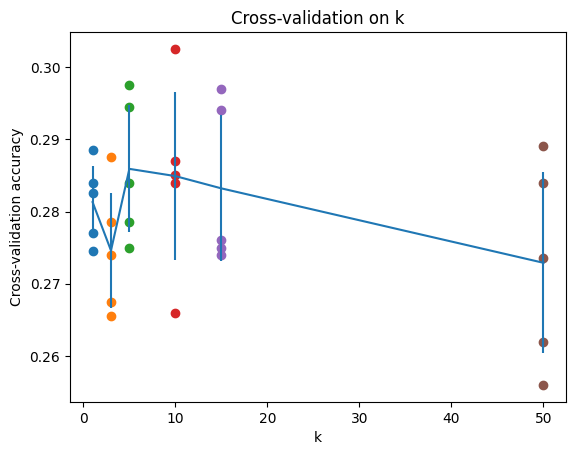

In [56]:
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
print(accuracies_mean)
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [55]:
# Choosing best value of k based on cross-validation results

# put the best K you found and report test accuracy
best_k = 5

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Computing and displaying the accuracy for best k found during cross-validation
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 296 / 1000 correct => accuracy: 0.296000
